# Multi step model (vector output approach)

In this notebook, we will demonstrate how to implement a RNN model to predict multiple time steps into the future. The model will be trained to output a vector, the elements of which are ordered predictions for future time steps. 

In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from collections import UserDict
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)

In [2]:
%run -i load_data.py
%run -i mape.py
%run -i TimeSeriesTensor.py
%run -i create_evaluation_df.py

In [3]:
if not os.path.exists(os.path.join('data', 'energy.csv')):
    %run extract_data.py
energy = load_data()
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [4]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

T = 6
HORIZON = 3

In [5]:
train = energy.copy()[energy.index < valid_start_dt][['load', 'temp']]

In [6]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

Create input tensors

In [7]:
tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, tensor_structure)

In [8]:
train_inputs.shifted_df.head(3)

tensor              target              X                                     \
feature                  y           load                          temp        
time step              t+1  t+2  t+3  t-5  t-4  t-3  t-2  t-1    t  t-5  t-4   
2012-01-01 05:00:00   0.18 0.23 0.29 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43   
2012-01-01 06:00:00   0.23 0.29 0.35 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40   
2012-01-01 07:00:00   0.29 0.35 0.37 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41   

tensor                                   
feature                                  
time step            t-3  t-2  t-1    t  
2012-01-01 05:00:00 0.40 0.41 0.42 0.41  
2012-01-01 06:00:00 0.41 0.42 0.41 0.40  
2012-01-01 07:00:00 0.42 0.41 0.40 0.39

In [9]:
train_inputs['X'][:3]

array([[[ 0.22,  0.42],
        [ 0.18,  0.43],
        [ 0.14,  0.4 ],
        [ 0.13,  0.41],
        [ 0.13,  0.42],
        [ 0.15,  0.41]],

       [[ 0.18,  0.43],
        [ 0.14,  0.4 ],
        [ 0.13,  0.41],
        [ 0.13,  0.42],
        [ 0.15,  0.41],
        [ 0.18,  0.4 ]],

       [[ 0.14,  0.4 ],
        [ 0.13,  0.41],
        [ 0.13,  0.42],
        [ 0.15,  0.41],
        [ 0.18,  0.4 ],
        [ 0.23,  0.39]]])

In [10]:
train_inputs['target'][:3]

array([[ 0.18,  0.23,  0.29],
       [ 0.23,  0.29,  0.35],
       [ 0.29,  0.35,  0.37]])

Construct validation set (keeping W hours from the training set in order to construct initial features)

In [11]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

## Implement the RNN

In [12]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping

Using TensorFlow backend.


In [13]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 100

In [14]:
model = Sequential()
model.add(GRU(LATENT_DIM, input_shape=(T, 2)))
model.add(Dense(HORIZON))

In [15]:
model.compile(optimizer='RMSprop', loss='mse')

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 5)                 120       
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 18        
Total params: 138
Trainable params: 138
Non-trainable params: 0
_________________________________________________________________


In [17]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [18]:
model.fit(train_inputs['X'],
          train_inputs['target'],
          batch_size=BATCH_SIZE,
          epochs=EPOCHS,
          validation_data=(valid_inputs['X'], valid_inputs['target']),
          callbacks=[earlystop],
          verbose=1)

Train on 23368 samples, validate on 1461 samples
Epoch 1/100
23368/23368 [==============================] - 4s 170us/step - loss: 0.0352 - val_loss: 0.0087
Epoch 2/100
23368/23368 [==============================] - 4s 155us/step - loss: 0.0066 - val_loss: 0.0049
Epoch 3/100
23368/23368 [==============================] - 4s 171us/step - loss: 0.0047 - val_loss: 0.0043
Epoch 4/100
23368/23368 [==============================] - 4s 156us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 5/100
23368/23368 [==============================] - 4s 161us/step - loss: 0.0038 - val_loss: 0.0034
Epoch 6/100
23368/23368 [==============================] - 4s 167us/step - loss: 0.0036 - val_loss: 0.0033
Epoch 7/100
23368/23368 [==============================] - 3s 149us/step - loss: 0.0035 - val_loss: 0.0036
Epoch 8/100
23368/23368 [==============================] - 4s 165us/step - loss: 0.0034 - val_loss: 0.0034
Epoch 9/100
23368/23368 [==============================] - 3s 148us/step - loss: 0.0033 - val_l

23368/23368 [==============================] - 4s 164us/step - loss: 0.0023 - val_loss: 0.0021
Epoch 77/100
23368/23368 [==============================] - 3s 149us/step - loss: 0.0023 - val_loss: 0.0021


## Evaluate the model

In [19]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

In [20]:
predictions = model.predict(test_inputs['X'])

In [21]:
predictions

array([[ 0.23,  0.31,  0.34],
       [ 0.29,  0.35,  0.35],
       [ 0.36,  0.39,  0.38],
       ..., 
       [ 0.61,  0.53,  0.45],
       [ 0.56,  0.49,  0.4 ],
       [ 0.54,  0.46,  0.38]], dtype=float32)

In [22]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,726.38","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,930.68","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,145.08","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,284.40","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,427.70","3,436.00"


Compute MAPE for each forecast horizon

In [23]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.02
t+2   0.03
t+3   0.05
Name: APE, dtype: float64

Compute MAPE across all predictions

In [24]:
mape(eval_df['prediction'], eval_df['actual'])

0.03295801429751457

Plot actuals vs predictions at each horizon for first week of the test period 

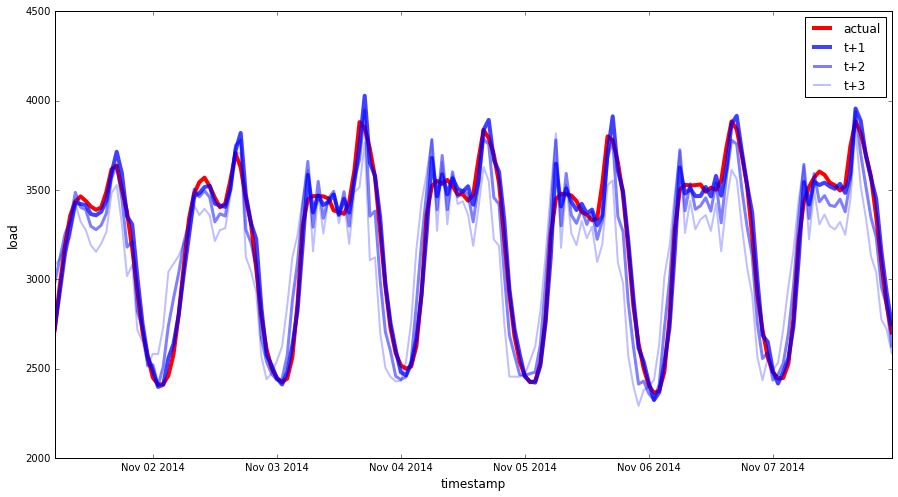

In [25]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0)
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='blue', linewidth=4.0, alpha=0.75)
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5)
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25)
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()